# 作业：水果自由

最近由于车厘子的降价，水果自由这个词又重新火了起来，因此考虑使用爬虫爬取
我比较喜欢的两种水果：荔枝和西瓜的价格，分析它们在全国的价格分布

所做的工作包括：爬取美团上荔枝的价格并存入csv文件； 
                对数据进行清洗，包括去除荔枝味饮料等，以及统一度量； 
                找出全国荔枝价格最高和最低的地区，分析产地对价格的影响； 
                展示全国的荔枝价格分布； 
                对西瓜的操作与荔枝类似。

### 1.数据爬取
- 一是一些基本设置
- 二是爬取美团网获得数据；
- 三是展示部分数据；

#### 1.部分爬虫代码（此处未运行，后面的分析均为读取之前存的csv文件）

In [ ]:
import time
import json
import requests
import pandas as pd
from pymongo import MongoClient

mt_data = {'geoType': '2', 'cityId': '1', 'start': '0', 'queryType': '12002', 'keyword': '荔枝',
        'entranceId': '0', 'uuid': '16abf817564c8-0f17bb52c7e85c-37617604-fa000-16abf817564c8',
           'platform': '3', 'partner': '4',
        'originUrl': 'http://h5.waimai.meituan.com/waimai/mindex/searchresults?'
                     'queryType=12002&keyword=%E8%8D%94%E6%9E%9D&entranceId=0&qwTypeId=11002&mode=search',
        'riskLevel': '71', 'optimusCode': '10', 'wm_actual_latitude': '23144351', 'wm_actual_longitude': '113337841'}


mt_headers = { 'Cookie': '_lxsdk_s=16abfa7f904-d87-043-14d%7C%7C7;'
                         ' openh5_uuid=2D72E5C2609F2792812E24DBD270517FB1C9D62702619D33328C9300DD6FC302;'
                         ' terminal=i; w_actual_lat=23131972; w_actual_lng=113327507;'
                         ' w_utmz="utm_campaign=(direct)&utm_source=5000&utm_medium=(none)&utm_'
                         'content=(none)&utm_term=(none)"; '
                         'openh5_uuid=2D72E5C2609F2792812E24DBD270517FB1C9D62702619D33328C9300DD6FC302;'
                         ' uuid=2D72E5C2609F2792812E24DBD270517FB1C9D62702619D33328C9300DD6FC302; '
                         'au_trace_key_net=default; wm_order_channel=default; '
                         'w_addr=%E5%A4%A9%E6%B2%B3%E5%8C%BA%E7%9F%B3%E7%89%8C%E5%A4%A9%E7%AB%8B%'
                         'E5%A4%A7%E5%8E%A6(%E4%BA%94%E5%B1%B1%E8%B7%AF%E8%A5%BF); '
                         'w_uuid=_2vrZM6Cyta66ENmXNBXbzZh_AeqYk-43e0meKNSBJt_HH_bbAAidBBpL3lIcCNJ; '
                         '__mta=212228651.1557993617867.1557993617867.1557993617867.1; '
                         '_lx_utm=utm_source%3Dbing%26utm_medium%3Dorganic%26utm_term%3D%25E7%25BE%258E%25E5'
                         '%259B%25A2%25E5%25A4%2596%25E5%258D%2596; '
                         '_lxsdk=2D72E5C2609F2792812E24DBD270517FB1C9D62702619D33328C9300DD6FC302; '
                         '_lxsdk_cuid=16abfa7f900c8-0558d17ad177f6-7f7f3265-3d10d-16abfa7f901c8; '
                         'JSESSIONID=1gjxbn5o5kddo1d55838n5r4es; webp=0; utm_source=0; '
                         'w_visitid=43c6eacd-00b4-489f-8440-497e12a5d732; wx_channel_id=0; '
                         'IJSESSIONID=mu3yrzj1osjb1alojuq6yymcu; ci=20; cityname=%'
                         'E5%B9%BF%E5%B7%9E; iuuid=2D72E5C2609F2792812E24DBD270517FB1C9D62702619D33328C9300DD6FC302;'
                         ' latlng=23.134567%2C113.322089%2C1557993607532; nodown=yes'
,
           'Host': 'i.waimai.meituan.com',
           'Origin': 'http://h5.waimai.meituan.com',
           'Referer': 'http://h5.waimai.meituan.com/waimai/mindex/searchresults?queryType=12002'
                      '&keyword=%E8%8D%94%E6%9E%9D&entranceId=0&qwTypeId=11002&mode=search',
           'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like Mac OS X) AppleWebKit/604.1.38'
                         ' (KHTML, like Gecko) Version/11.0 Mobile/15A372 Safari/604.1'}

class PriceCrawler(object):
    def __init__(self, fruit):
        self.city_data = pd.read_csv('city_data.csv')
        self.loc_url = 'https://apis.map.qq.com/jsapi?qt=geoc&addr={}&key=TU5BZ-MKD3W-L43RW-O3ZBW-GWMZK-QBB25' \
                       '&output=jsonp&pf=jsapi&ref=jsapi&cb=qq.maps._svcb2.geocoder0'
        self.mt_url = 'http://i.waimai.meituan.com/openh5/search/poi?_={}' \
                      '&X-FOR-WITH=mP9tsFEnb9hfrEHTrmpMSE8Y1za6R%2B5jgLtj%2FaCEkv9mUzq9C90xx7W8ztsISSWV3ccaw7' \
                      'm5H2%2FEKCO4ybaM13BHe5NUV%2BwIfo17kPUjMBKTvhGk21LspnQJ8CJAiH6KAI2CF5K44l%2BJjx1VgIpnVg%3D%3D'
        client = MongoClient(host='localhost', port=27017)
        db = client.Fruit
        self.col = db.lychee

        mt_data['keyword'] = fruit

    def get_lat_lon(self, city):
        try:
            loc_res = requests.get(self.loc_url.format(city+'市'), timeout=5)
            loc_data = json.loads(loc_res.text[loc_res.text.find('(')+1: -1])
            if loc_data['info']['error'] == 0:
                lon = int(float(loc_data['detail']['pointx'])*1000000)
                lat = int(float(loc_data['detail']['pointy'])*1000000)
                return lon, lat, 1
            else:
                return None, None, 0
        except:
            print('Can not get city: {}'.format(city))
            return None, None, 0

    def get_fruit_data(self):
        idx = self.city_data.shape[0]
        for i in range(idx):
            city = self.city_data.iloc[i]['city']
            province = self.city_data.iloc[i]['province']
            mt_data['wm_actual_longitude'], mt_data['wm_actual_latitude'], validate = self.get_lat_lon(city)
            if validate:
                print('Crawling data of city: {}, province: {}'.format(city, province))
                res = requests.post(self.mt_url.format(int(time.time()*1000)),
                                    headers=mt_headers,
                                    data=mt_data)
                time.sleep(5)
                self.format_response(res.json(), city, province)

    def format_response(self, res, city, province):
        if len(res['data']['searchPoiList']) > 0:
            for store in res['data']['searchPoiList']:
                store_name = store['name']
                print('Crawling data of Store: {}'.format(store_name))
                for prod in store['productList']:
                    del prod['logField']
                    del prod['picture']
                    del prod['productLabelPictureList']
                    prod['city'] = city
                    prod['province'] = province
                    prod['store'] = store_name
                    self.col.insert_one(prod)


if __name__ == '__main__':
    pc = PriceCrawler('荔枝')
    pc.get_fruit_data()


#### 2.一些设置

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('ggplot')
from pylab import mpl
sns.set(font_scale=1.5)
mpl.rcParams['font.sans-serif'] = ['SimHei']  #解决seaborn中文字体显示问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
%matplotlib inline

#### 3.读取数据文件并展示部分数据

In [2]:
lc = pd.read_csv('D:\work\lychee.csv')

In [3]:
lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 12 columns):
monthSales       1692 non-null int64
originalPrice    1692 non-null float64
praiseContent    1692 non-null object
price            1692 non-null float64
productName      1692 non-null object
productSpuId     1692 non-null int64
productStatus    1692 non-null int64
promotionInfo    476 non-null object
wmPoiId          1692 non-null int64
city             1692 non-null object
province         1692 non-null object
store            1692 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 158.8+ KB


In [4]:
lc.sample(5)

,monthSales,originalPrice,praiseContent,price,productName,productSpuId,productStatus,promotionInfo,wmPoiId,city,province,store
1566,4,10.8,赞0,8.99,妃子笑荔枝约250g,1530091727,0,8.32折,886194668860648,西安,陕西省,龙门头（含光门店）
93,4,30.0,赞0,30.00,广西 妃子笑 荔枝 肉大核小超甜,855598498,0,NaN,847784776333064,巴彦淖尔,内蒙古自治区,西安小罗精品果蔬
647,1,28.0,赞0,25.00,妃子笑荔枝（500g）,1514498026,0,8.93折,923328956106326,东阳,浙江省,小红平价水果
1527,2,29.8,赞0,29.80,香蕉 妃子笑 杨梅500克,1488715708,0,NaN,906728907474180,都匀,贵州省,阿强水果副食店
957,0,18.8,赞0,16.80,空运妃子笑鲜荔枝半斤,1543393572,0,8.94折,949901918780257,济宁,山东省,李家水果快送（炒酸奶.水果捞）


### 2.数据清洗
- 一是把不是荔枝的记录清掉，比如说有些是奶茶店卖的“妃子笑芝芝”；
- 二是统一度量标准，单位比较乱，有以克为单位的，以千克为单位的，还有以斤、半斤为单位的；
- 三是去重、数据类型转换等

#### 1. 清理不是荔枝的记录

In [5]:
lc = lc[-lc['store'].str.contains('茶|奶|咖啡|披萨|冷饮|汁|餐厅|锅|面皮|鱼|饭')]
lc = lc[-lc['productName'].str.contains('茶|奶|咖啡|披萨|冷饮|汁|餐厅|锅|面皮|箱|饮料')]

In [6]:
lc.sample(5)

,monthSales,originalPrice,praiseContent,price,productName,productSpuId,productStatus,promotionInfo,wmPoiId,city,province,store
1390,19,10.90,赞0,7.90,【特惠】A级-妃子笑荔枝（粒果）1份/不少于250g,1523110432,0,7.25折,863358327740633,湛江,广东省,百果园（湛江金城一横路店）
901,0,18.50,赞0,18.50,A级-妃子笑荔枝（粒果）1份/不少于500g,1515355043,0,NaN,885520359001373,丰城,江西省,百果园（宜春梦祥路店）
1660,0,21.99,赞0,21.99,海南妃子笑荔枝约500g/份,858169352,0,NaN,1042385449543833,北京,北京市,比邻鲜（二毛店）
35,0,8.00,赞0,8.00,妃子笑（荔枝西柚）,1054129061,0,NaN,1069327779426292,定州,河北省,果然时光（大世界共享星厨店）
903,0,18.50,赞0,18.50,A级-妃子笑荔枝（粒果）1份/不少于500g,1515153751,0,NaN,846418976763997,丰城,江西省,百果园（宜春雷焕路店）


#### 2. 统一度量标准

In [7]:
pat_kg = r'([\d|.]*)kg'
pat_g = r'(\d*)g'
pat_jin = r'([\d|.]*)斤'
pat_ke = r'(\d*)克'
def get_weight(data):
    if 'kg' in data:
        return float(re.findall(pattern=pat_kg, string=data)[0])*1000
    elif 'Kg' in data:
        return float(1000)
    elif 'g' in data:
        if re.findall(pattern=pat_g, string=data)[0] != '':
            return float(re.findall(pattern=pat_g, string=data)[0])
    elif '半斤'in data:
        return float(250)
    elif '一斤' in data:
        return float(500)
    elif '每斤' in data:
        return float(500)
    elif '二斤' in data:
        return float(1000)
    elif '三斤' in data:
        return float(1500)
    elif '/斤' in data:
        return float(500)
    elif '斤' in data:
        jin = re.findall(pattern=pat_jin, string=data)
        if len(jin) > 0 and jin[0] != '':
            return float(jin[0])*500
        else:
            return float(500)
    elif '克' in data:
        return float(re.findall(pattern=pat_ke, string=data)[0])
    else:
        return float(500)

In [8]:
lc['gram'] = lc['productName'].apply(get_weight)

In [9]:
lc[['productName', 'gram']].sample(5)

,productName,gram
226,妃子笑,500.0
123,新摘妃子笑荔枝（斤）,500.0
1253,海南 新鲜 小核妃子笑 一斤,500.0
1272,海南 妃子笑荔枝/500g 500g,500.0
1241,妃子笑荔枝 约500g/份,500.0


In [10]:
lc['price_per_jin'] = lc['price'] / (lc['gram']/500)

In [11]:
lc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1396 entries, 0 to 1691
Data columns (total 14 columns):
monthSales       1396 non-null int64
originalPrice    1396 non-null float64
praiseContent    1396 non-null object
price            1396 non-null float64
productName      1396 non-null object
productSpuId     1396 non-null int64
productStatus    1396 non-null int64
promotionInfo    448 non-null object
wmPoiId          1396 non-null int64
city             1396 non-null object
province         1396 non-null object
store            1396 non-null object
gram             1395 non-null float64
price_per_jin    1395 non-null float64
dtypes: float64(4), int64(4), object(6)
memory usage: 163.6+ KB


In [12]:
lc.sample(5)

,monthSales,originalPrice,praiseContent,price,productName,productSpuId,productStatus,promotionInfo,wmPoiId,city,province,store,gram,price_per_jin
1308,0,19.9,赞0,19.90,妃子笑荔枝 500g,1543586110,0,NaN,958131076116431,湘乡,湖南省,鲜果庄园,500.0,19.900000
736,0,25.0,赞0,25.00,【核小纯甜】火山口妃子笑 一斤盒装,1543599872,0,NaN,845491263810671,桐城,安徽省,四季果业,500.0,25.000000
1442,13,26.9,赞0,14.90,【1斤】A级-妃子笑荔枝（粒果）1份/不少于500g,1523327232,0,5.54折,944855332210978,海口,海南省,百果园(海口海德路店),500.0,14.900000
1592,10,15.8,赞0,9.90,海南 妃子笑荔枝 （250g）,1528461979,0,6.27折,989883769312501,兰州,甘肃省,果果家（兰州桃花苑店）,250.0,19.800000
1282,0,24.8,赞0,16.81,【新鲜到货】妃子笑荔枝 600g/份,1541194736,0,6.78折,909739679611644,娄底,湖南省,绿叶水果（娄底株山国际店）,600.0,14.008333


#### 3. 去重、数据类型转换

In [13]:
lc.drop_duplicates(subset='productSpuId', inplace=True)

In [14]:
lc['price_per_jin'].mean()

22.144160908182368

### 3.数据分析：
1. 荔枝价格整体情况如何？
2. 哪些城市吃荔枝最贵？
3. 原产地是否有价格优势？
4. 全国荔枝平均价格图
5. 平均工资水平能否实现荔枝自由？

#### 1. 荔枝价格整体情况如何？

In [15]:
lc['price_per_jin'].describe()

count    1394.000000
mean       22.144161
std         9.891200
min         0.010000
25%        15.800000
50%        19.800000
75%        25.800000
max        98.000000
Name: price_per_jin, dtype: float64

D:\software\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '价格/斤')

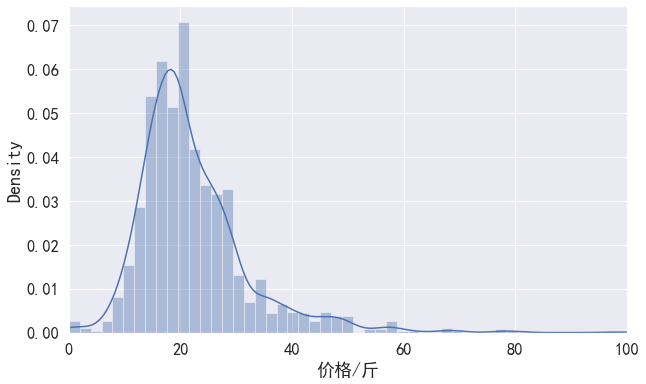

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(list(lc['price_per_jin'].dropna()), ax=ax)
ax.set_xlim(0, 100)
ax.set_xlabel('价格/斤')

In [17]:
top5_store = lc.loc[lc['price_per_jin'].nlargest().index][['productName', 'price', 'city', 'store']]

In [18]:
def anonymous(data):
    rpc_str = data[1:-1]
    rpc_str_len = len(rpc_str)
    return data.replace(rpc_str, '*'*rpc_str_len)
    

top5_store['store'] = top5_store['store'].apply(anonymous)
top5_store

,productName,price,city,store
1648,海南妃子笑荔枝【500g】,98.0,银川,F******店
249,妃子笑荔枝,80.0,洮南,谷***果
1669,海南妃子笑500g,78.0,上海,绿**********）
1671,海南妃子笑500g,78.0,上海,绿*****园
459,妃子笑荔枝,70.0,兴化,果***你


In [19]:
less_than_3 = lc[(lc['price_per_jin']<3)&(lc['price']>0.1)][['price', 'productName', 'city', 'province', 'store']]
less_than_3['store'] = less_than_3['store'].apply(anonymous)
less_than_3

,price,productName,city,province,store
163,2.00,荔枝 1颗 （妃子笑）,新民,辽宁省,街*********店
1214,0.57,妃子笑荔枝 1粒 尝鲜,长沙,湖南省,果**********）
1242,0.57,妃子笑荔枝 1粒 尝鲜,株洲,湖南省,果**********）
1245,0.57,妃子笑荔枝 1粒 尝鲜,株洲,湖南省,果**********）
1251,0.57,妃子笑荔枝 1粒 尝鲜,湘潭,湖南省,果*********）
1256,0.57,妃子笑荔枝 1粒 尝鲜,湘潭,湖南省,果*********）
1450,2.00,妃子笑荔枝/个,三亚,海南省,亚***市


In [20]:
lc = lc[lc['price_per_jin']>3]

#### 2. 哪些城市吃荔枝最贵？

In [21]:
top10_city = lc.groupby('city')['price_per_jin'].mean().nlargest(10)

In [22]:
pip install pyecharts==0.1.9.4

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install echarts-themes-pypkg

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install wheel

Note: you may need to restart the kernel to use updated packages.


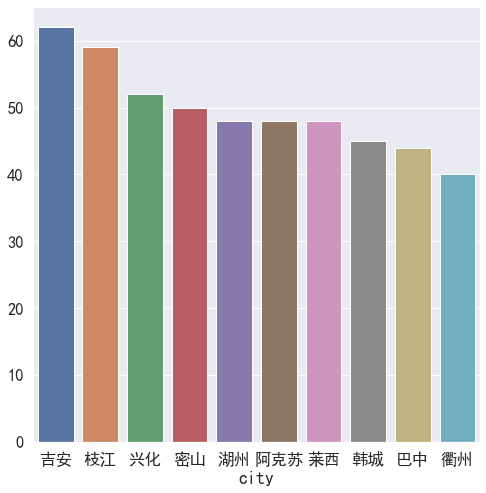

In [29]:

plt.figure(figsize=(8, 8))
sns.barplot(x=top10_city.index, y=np.round(top10_city.values, 0))
plt.show()

#### 3. 原产地是否有价格优势？
国内原产地为：广东、福建、海南

In [30]:
small10_city = lc[lc['province'].isin(['广东省', '福建省', '海南省'])].groupby('city')['price_per_jin'].mean().nsmallest(5)

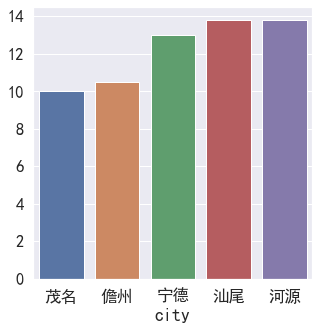

In [33]:

plt.figure(figsize=(5, 5))
sns.barplot(x=small10_city.index, y=np.round(small10_city.values, 1))
plt.show()

In [34]:
small10_city

city
茂名    10.0
儋州    10.5
宁德    13.0
汕尾    13.8
河源    13.8
Name: price_per_jin, dtype: float64

In [35]:
lc[lc['city'].isin(['广州', '深圳', '厦门'])].groupby('city')['price_per_jin'].mean()

city
厦门    18.452381
广州    18.426316
深圳    18.156944
Name: price_per_jin, dtype: float64

#### 4. 全国荔枝平均价格图

In [36]:
lc_province = lc.groupby('province')['price_per_jin'].mean().reset_index(name='price')

In [37]:
lc_province['province'] = lc_province['province'].str.replace('省|市|自治区|回族自治区|壮族自治区|维吾尔自治区', '')

In [38]:
# 政治上要正确，用平均价格补足西藏和台湾的荔枝价格
lc_province = pd.concat([lc_province, pd.DataFrame({'province':['西藏', '台湾'],
                                                  'price':[22, 22]})])

In [39]:
lc_province['price'].max()

39.8

In [56]:
#from pyecharts import CurrentConfig, NotebookType, OnlineHostType
# CurrentConfig.ONLINE_HOST = "https://www.echartsjs.com/examples/vendors/echarts/"
#CurrentConfig.ONLINE_HOST = "https://assets.pyecharts.org/assets/"
from pyecharts import Map

import os

map = Map("全国各省份荔枝平均价格图", width=800, height=800)
map.add(
    "",
    lc_province['province'],
    np.round(lc_province['price'], 0),
    maptype="china",
    is_visualmap=True,
    visual_text_color="#000",
    visual_range=[0, 40],
    is_label_show=True
)
map.render()

os.system("render.html")

0

#### 注：这里和后面的map图由于环境等问题没有解决，最后没有交互展示只能网页展示了QaQ

In [57]:
salary = pd.read_csv('D:\work\salary.csv') 

In [58]:
salary = salary[['地区', '标准实行时间', '第一档']]

In [59]:
lc_province = lc_province.merge(salary, left_on='province', right_on='地区')

In [60]:
lc_province['salary_lc'] = np.round(lc_province['第一档']/lc_province['price'], 1)

In [61]:
lc_province['salary_lc'].max()

114.8

In [62]:
lc_province

,province,price,地区,标准实行时间,第一档,salary_lc
0,上海,35.817612,上海,2018.04.01,2420,67.6
1,云南,23.634825,云南,2018.05.01,1670,70.7
2,内蒙古,19.870800,内蒙古,2017.08.01,1760,88.6
3,北京,21.416765,北京,2018.09.01,2120,99.0
4,吉林,17.073333,吉林,2017.10.01,1780,104.3
5,四川,24.567586,四川,2018.07.01,1780,72.5
6,天津,32.135556,天津,2017.07.01,2050,63.8
7,宁夏,29.023333,宁夏,2017.10.01,1660,57.2
8,安徽,23.613700,安徽,2015.11.01,1520,64.4
9,山东,24.235354,山东,2018.06.01,1910,78.8


In [64]:
import os
map = Map("各省最低工资可购买荔枝斤数", width=800, height=800)
map.add(
    "",
    lc_province['province'],
    lc_province['salary_lc'],
    maptype="china",
    is_visualmap=True,
    visual_text_color="#000",
    visual_range=[0, 115],
    is_label_show=True
)
map.render()

os.system("render.html")

0

# 4. 西瓜自由(与荔枝类似）

In [66]:
wm = pd.read_csv('D:\work\watermelon.csv')

In [67]:
wm.sample(5)
# 黑美人、麒麟、红玉西瓜、墨童西瓜、冰镇西瓜、8428西瓜、无籽西瓜、山东甜西瓜、本地西瓜

,monthSales,originalPrice,praiseContent,price,productName,productSpuId,productStatus,promotionInfo,wmPoiId,city,province,store
2501,94,11.0,赞0,7.00,西瓜沙冰700ml,608067671,0,6.36折,1079846154338269,辽阳,辽宁省,阿牛与仙草（烧仙草专卖店）
11523,8,28.0,赞0,28.00,解暑西瓜果切,1066852567,0,NaN,1068863922911685,当阳,湖北省,果果多（广洲路店）
794,0,40.0,赞0,40.00,黑美人西瓜 西瓜 一个价格大约重九斤左右,1198852267,0,NaN,898151857792088,冀州,河北省,沃林水果店
8918,3,13.8,赞0,13.52,果切 哈密瓜 凤梨 西瓜320g,1021591311,0,9.8折,922568746877138,平度,山东省,玲珑鲜果
7492,11,8.0,赞1,8.00,西瓜冰沙,215962239,0,NaN,854867177422113,武夷山,福建省,思味甜品店（市区店）


### 1.数据处理
- 一是把不是西瓜的记录清掉；
- 二是统一度量标准，单位比较乱，有以克为单位的，以千克为单位的，还有以斤、半斤为单位的；
- 三是去重、数据类型转换等

#### 1. 清理不是西瓜的记录

In [68]:
wm  = wm[wm['productName'].str.contains('黑美人|麒麟|红玉|墨童|冰镇西瓜|8428|无籽西瓜|山东甜西瓜|本地西瓜')]
wm  = wm[-wm['productName'].str.contains('汽水|切|净|盒')]

#### 2. 统一度量标准

In [69]:
def get_weight_wm(data):
    if 'kg' in data:
        kg = re.findall(pattern=pat_kg, string=data)
        if len(kg) >0 and kg[0] != '':
            return float(kg[0])*1000
    elif 'Kg' in data:
        return float(1000)
    elif 'g' in data:
        if re.findall(pattern=pat_g, string=data)[0] != '':
            return float(re.findall(pattern=pat_g, string=data)[0])
    elif '半斤'in data:
        return float(250)
    elif '一斤' in data:
        return float(500)
    elif '每斤' in data:
        return float(500)
    elif '十二斤' in data:
        return float(6000)
    elif '二斤' in data:
        return float(1000)
    elif '三斤半' in data:
        return float(1750)
    elif '三斤' in data:
        return float(1500)
    elif '四斤' in data:
        return float(2000)
    elif '五斤' in data:
        return float(2500)
    elif '六斤半' in data:
        return float(3250)
    elif '六斤' in data:
        return float(3000)
    elif '七斤' in data:
        return float(3500)
    elif '八斤' in data:
        return float(4000)
    elif '九斤' in data:
        return float(4500)
    elif '十斤' in data:
        return float(5000)    
    elif '/斤' in data:
        return float(500)
    elif '斤' in data:
        jin = re.findall(pattern=pat_jin, string=data)
        if len(jin) > 0 and jin[0] != '':
            return float(jin[0])*500
        else:
            return float(500)
    elif '克' in data:
        ke = re.findall(pattern=pat_ke, string=data)
        if len(ke) > 0 and ke[0] != '':
            return float(ke[0])
    elif '/个' in data:
        return float(5000)
    elif '半个' in data:
        return float(2500)
    elif '个' in data:
        return float(5000)
    else:
        return np.nan

In [70]:
wm['gram'] = wm['productName'].apply(get_weight_wm)

In [71]:
wm[['productName', 'gram', 'price']].sample(5)

,productName,gram,price
16752,本地西瓜 500g,500.0,3.5
1114,麒麟瓜 个,5000.0,50.0
4720,海南 海南麒麟西瓜 1个,5000.0,70.0
4714,海南麒麟西瓜,NaN,65.0
8358,麒麟瓜皮微厚 4斤左右,2000.0,22.8


In [72]:
wm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 18 to 17689
Data columns (total 13 columns):
monthSales       1523 non-null int64
originalPrice    1523 non-null float64
praiseContent    1523 non-null object
price            1523 non-null float64
productName      1523 non-null object
productSpuId     1523 non-null int64
productStatus    1523 non-null int64
promotionInfo    125 non-null object
wmPoiId          1523 non-null int64
city             1523 non-null object
province         1523 non-null object
store            1523 non-null object
gram             943 non-null float64
dtypes: float64(3), int64(4), object(6)
memory usage: 166.6+ KB


In [73]:
wm = wm[wm['gram'].notnull()]

In [74]:
wm['price_per_jin'] = wm['price'] / (wm['gram']/500)

### 2.西瓜数据分析

#### 1. 西瓜价格整体情况如何？

In [75]:
wm

,monthSales,originalPrice,praiseContent,price,productName,productSpuId,productStatus,promotionInfo,wmPoiId,city,province,store,gram,price_per_jin
37,0,65.80,赞0,65.80,麒麟西瓜 /个,1269632110,0,NaN,1024690184314426,唐山,河北省,乐家超市,5000.0,6.580000
162,11,29.50,赞0,29.50,黑美人西瓜 进口越南西部 个,1313114869,0,NaN,943468057787314,承德,河北省,海峰水果蔬菜超市,5000.0,2.950000
163,3,37.99,赞0,37.99,麒麟西瓜 半个,1298678405,0,NaN,943468057787314,承德,河北省,海峰水果蔬菜超市,2500.0,7.598000
165,0,39.90,赞0,39.90,早春红玉西瓜 皮薄 口感甘甜 个,1532341783,0,NaN,943468057787314,承德,河北省,海峰水果蔬菜超市,5000.0,3.990000
167,0,68.00,赞0,68.00,2484冰糖麒麟西瓜 5kg,1328735166,0,NaN,960420293659451,承德,河北省,丁丁果儿（卓越家园店）,5000.0,6.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17377,0,5.00,赞0,5.00,红玉西瓜 500g,1447147231,0,NaN,933508028582773,博乐,新疆维吾尔自治区,仁和春天生活广场,500.0,5.000000
17509,2,24.00,赞0,24.00,红玉西瓜 一个西瓜3公斤左右 3000g,1201568098,0,NaN,1111942444925361,伊宁,新疆维吾尔自治区,琪梦超市,3000.0,4.000000
17516,1,36.00,赞0,36.00,麒麟西瓜@双击666 约3000g,760380209,0,NaN,867240978191061,伊宁,新疆维吾尔自治区,杜林蔬菜店,3000.0,6.000000
17667,3,40.00,赞0,40.00,红玉西瓜 4600g,1499859520,0,NaN,1053732753144680,五家渠,新疆维吾尔自治区,田园果蔬,4600.0,4.347826


In [76]:
wm[['price_per_jin', 'productName', 'price', 'gram']].sample(5)

,price_per_jin,productName,price,gram
3614,8.600000,海南麒麟西瓜 个,86.0,5000.0
8098,3.666667,海南 麒麟瓜 散称包甜多汁 4-6斤/个,22.0,3000.0
8861,9.600000,麒麟瓜 500g,9.6,500.0
6918,222.000000,黑美人西瓜 500g,222.0,500.0
14864,999.000000,黑美人西瓜 500g,999.0,500.0


In [77]:
wm = wm[wm['price_per_jin']<20]

In [78]:
wm['price_per_jin'].describe()

count    837.000000
mean       6.345770
std        2.977894
min        0.016667
25%        4.444444
50%        6.000000
75%        7.718182
max       19.980000
Name: price_per_jin, dtype: float64

D:\software\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '价格/斤')

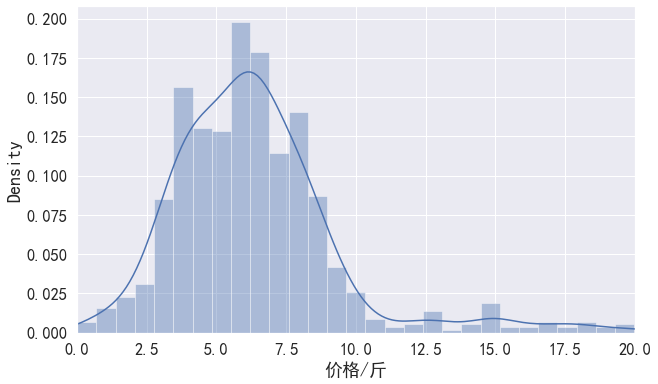

In [79]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(list(wm['price_per_jin'].dropna()), ax=ax)
ax.set_xlim(0, 20)
ax.set_xlabel('价格/斤')

#### 2.哪里西瓜最贵

In [84]:
top10_city = lc.groupby('city')['price_per_jin'].mean().nlargest(10)

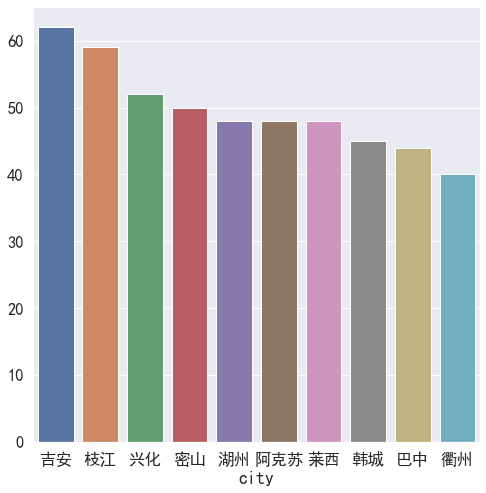

In [85]:
plt.figure(figsize=(8, 8))
sns.barplot(x=top10_city.index, y=np.round(top10_city.values, 0))
plt.show()

#### 3. 全国西瓜平均价格图

In [80]:
wm_province = wm.groupby('province')['price_per_jin'].mean().reset_index(name='price')

In [81]:
wm_province['province'] = wm_province['province'].str.replace('省|市|自治区|回族自治区|壮族自治区|维吾尔自治区', '')

In [82]:
wm_province['price'].max()

9.385535714285714

In [83]:
import os
map = Map("全国各省份西瓜平均价格图", width=800, height=800)
map.add(
    "",
    wm_province['province'],
    np.round(wm_province['price'], 1),
    maptype="china",
    is_visualmap=True,
    visual_text_color="#000",
    visual_range=[0, 10],
    is_label_show=True
)
map.render()

os.system("render.html")

0

# 本次作业到此结束~~~~